## Video 4 - Building an RNN Model with Word Indexing

In [1]:
import nltk
import pandas as pd
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score
from torch.nn.utils.rnn import pad_sequence
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

It checks if a CUDA-enabled GPU is present using torch.cuda.is_available() and sets the device variable to "cuda" to utilize the GPU's processing power for faster computation. 

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
# read the dataset
train = pd.read_csv('train.csv')
validation = pd.read_csv('validation.csv')
test = pd.read_csv('test.csv')

In [4]:
train.shape, validation.shape, test.shape

((17877, 5), (3831, 5), (3831, 5))

In [5]:
import re

def preprocess_text(text):
    # Check if the text is a string
    if not isinstance(text, str):
        return []
    
    # Keep only letters and whitespaces
    pattern = f"[a-zA-Z\s]"
    text = ''.join(re.findall(pattern, text))
    
    # Convert to lowercase
    text = text.lower()
    
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
#     tokens = ' '.join(tokens)
    
    return tokens


<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
/var/folders/fq/kr6gv5l17pd4j572n0_n3f2c0000gn/T/ipykernel_42108/2059751485.py:9: SyntaxWarning: invalid escape sequence '\s'
  pattern = f"[a-zA-Z\s]"


In [6]:
#apply the preprocess text to 
train['user_review'] = train['user_review'].apply(preprocess_text)
validation['user_review'] = validation['user_review'].apply(preprocess_text)
test['user_review'] = test['user_review'].apply(preprocess_text)

In [7]:
#check the head of train data
train.head()

,review_id,title,year,user_review,user_suggestion
0,460,Black Squad,2018.0,"[early, access, reviewvery, great, shooter, th...",1
1,2166,Tree of Savior (English Ver.),2016.0,"[i, love, love, love, playing, this, gamesuper...",1
2,17242,Eternal Card Game,2016.0,"[early, access, reviewas, a, fan, of, mtg, and...",1
3,6959,Tactical Monsters Rumble Arena,2018.0,"[turn, based, strategy, game, similiar, to, ff...",1
4,8807,Yu-Gi-Oh! Duel Links,2017.0,"[this, game, has, an, insanely, huge, download...",0


As you can see, we have achieved our desired result.

In [8]:
def build_vocabulary(reviews):
    vocab = {}
    index = 1  # Start indexing from 1; reserve 0 for padding
    for review in reviews:
        for word in review:
            if word not in vocab:
                vocab[word] = index
                index += 1
    return vocab

In [9]:
# Concatenate all reviews to build the vocabulary
all_reviews = train['user_review'].tolist() + validation['user_review'].tolist() + test['user_review'].tolist()
vocab = build_vocabulary(all_reviews)
print("Vocabulary Length:", len(vocab))
first_50 = list(vocab.items())[:50]
for key, value in first_50:
    print(f'{key}: {value}')


Vocabulary Length: 104326
early: 1
access: 2
reviewvery: 3
great: 4
shooter: 5
that: 6
have: 7
originality: 8
in: 9
it: 10
but: 11
of: 12
course: 13
some: 14
newbies: 15
dont: 16
understand: 17
mechanic: 18
shooting: 19
which: 20
guns: 21
is: 22
same: 23
or: 24
not: 25
throught: 26
visual: 27
look: 28
and: 29
what: 30
to: 31
do: 32
rankedbut: 33
theres: 34
thing: 35
keeps: 36
me: 37
think: 38
how: 39
would: 40
game: 41
evolve: 42
sure: 43
its: 44
still: 45
i: 46
developers: 47
need: 48
speed: 49
up: 50



Zero padding is beneficial in maintaining a consistent length of input sequences for the model. Zero index is used to 


In [10]:
#Indexing reviews based on the vocabulary
def index_and_pad_reviews(reviews, vocab, max_length=100):
    """Index and pad tokenized reviews to a fixed length."""
    indexed_reviews = []
    for review in reviews:
        indexed_review = [vocab.get(word, 0) for word in review]  # Use vocab.get to handle unknown words
        # Truncate if review length exceeds max_length
        truncated_review = indexed_review[:max_length]
        # Pad review with zeros if it's shorter than max_length
        padded_review = truncated_review + [0] * (max_length - len(truncated_review))
        indexed_reviews.append(padded_review)
    return indexed_reviews

#### The problem of zero padding-
Imagine we have three text sentences that we want to convert to numerical form using word indexing technique that we just performed:

1. "The rapid advancement of technology in the field of artificial intelligence is creating new opportunities and challenges in both research and practical applications" (25 words)
2. "Artificial intelligence will revolutionize the way we interact with technology" (10 words)
3. "Machine learning transforms data into predictions" (6 words)

We'll convert each word into a numerical index for simplicity. Here's an example indexing:

- "The" -> [1]
- "Rapid" -> [2]
- "Advancement" -> [3]
- "Of" -> [4]
- "Technology" -> [5]
- "In" -> [6]
- "Field" -> [7]
- "Artificial" -> [8]
- "Intelligence" -> [9]
- "Is" -> [10]
- "Creating" -> [11]
- "New" -> [12]
- "Opportunities" -> [13]
- "And" -> [14]
- "Challenges" -> [15]
- "Both" -> [16]
- "Research" -> [17]
- "Practical" -> [18]
- "Applications" -> [19]
- "Will" -> [20]
- "Revolutionize" -> [21]
- "Way" -> [22]
- "We" -> [23]
- "Interact" -> [24]
- "With" -> [25]
- "Machine" -> [26]
- "Learning" -> [27]
- "Transforms" -> [28]
- "Data" -> [29]
- "Into" -> [30]
- "Predictions" -> [31]

Without padding, the numerical sequences for these sentences would be:

1. [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
2. [8, 9, 20, 21, 22, 23, 24, 25, 5]
3. [26, 27, 28, 29, 30, 31]

To ensure uniform input sizes for neural network training, we'll set the maximum sequence length to 10 and adjust the sequences accordingly:

1. [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] __(Truncated)__
2. [8, 9, 20, 21, 22, 23, 24, 25, 5, 0] __(Zero Padded)__
3. [26, 27, 28, 29, 30, 31, 0, 0, 0, 0] __(Zero Padded)__

In this setup:
- Sentence 1 is truncated after the 10th index.
- Sentence 2 is padded with one zero to reach the maximum length of 10.
- Sentence 3 is significantly padded with four zeros to also reach the length of 10.

Each "sentence" now is represented by a 10-element array, making it possible to feed them into a neural network in a uniform manner. The zeros are placeholders that do not carry any meaningful information but maintain the necessary structure for input data.

Note that, the padding that we have done is post-padding which is the more common form of padding. In certain cases prepadding can also be done, where zeros are added in the beginning of the sentence. You can think of pre and post padding as hyperparameters.

Now, each "sentence" is represented by a 10x1 matrix, making it possible to feed them into a neural network in a uniform manner. The zero vectors do not carry any meaningful information and are typically ignored by the model in terms of learning but provide the necessary structure for the input data.

In [11]:
#converting dataframe to list
train_review = train['user_review'].tolist()
test_review = test['user_review'].tolist()
validation_review = validation['user_review'].tolist()

In [12]:
# Index and pad reviews for each set
train_indexed = index_and_pad_reviews(train_review, vocab)
test_indexed = index_and_pad_reviews(test_review, vocab)
validation_indexed = index_and_pad_reviews(validation_review, vocab)

In [13]:
# Convert indexed reviews back to DataFrame for further use
train['user_review_indexed'] = train_indexed
test['user_review_indexed'] = test_indexed
validation['user_review_indexed'] = validation_indexed


In [14]:
train.head()

,review_id,title,year,user_review,user_suggestion,user_review_indexed
0,460,Black Squad,2018.0,"[early, access, reviewvery, great, shooter, th...",1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,2166,Tree of Savior (English Ver.),2016.0,"[i, love, love, love, playing, this, gamesuper...",1,"[46, 84, 84, 84, 85, 57, 86, 10, 58, 82, 87, 1..."
2,17242,Eternal Card Game,2016.0,"[early, access, reviewas, a, fan, of, mtg, and...",1,"[1, 2, 102, 82, 103, 12, 104, 29, 105, 57, 58,..."
3,6959,Tactical Monsters Rumble Arena,2018.0,"[turn, based, strategy, game, similiar, to, ff...",1,"[126, 127, 128, 41, 129, 31, 130, 131, 132, 9,..."
4,8807,Yu-Gi-Oh! Duel Links,2017.0,"[this, game, has, an, insanely, huge, download...",0,"[57, 41, 58, 159, 160, 161, 71, 81, 162, 82, 1..."


In [15]:
for i in range(3):
    print(train.user_review[i], '\n')

['early', 'access', 'reviewvery', 'great', 'shooter', 'that', 'have', 'originality', 'in', 'it', 'but', 'of', 'course', 'some', 'newbies', 'dont', 'understand', 'mechanic', 'of', 'shooting', 'which', 'guns', 'is', 'same', 'or', 'not', 'throught', 'visual', 'look', 'and', 'what', 'to', 'do', 'in', 'rankedbut', 'theres', 'thing', 'that', 'keeps', 'me', 'think', 'how', 'would', 'game', 'evolve', 'sure', 'its', 'still', 'in', 'early', 'access', 'but', 'i', 'think', 'developers', 'need', 'to', 'speed', 'up', 'process', 'of', 'finishing', 'game', 'cuz', 'still', 'comparing', 'to', 'other', 'games', 'this', 'game', 'has', 'low', 'number', 'of', 'community', 'and', 'some', 'things', 'that', 'makes', 'player', 'think', 'that', 'black', 'squad', 'is', 'another', 'copy', 'of', 'csgo', 'and', 'he', 'would', 'not', 'download', 'iti', 'hope', 'you', 'understand', 'my', 'message', 'i', 'really', 'like', 'this', 'game', 'but', 'i', 'dont', 'think', 'it', 'can', 'keep', 'me', 'for', 'a', 'year'] 

['i'

In [16]:
for i in range(3):
    print(train_indexed[:3][i], '\n')

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 12, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 9, 33, 34, 35, 6, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 9, 1, 2, 11, 46, 38, 47, 48, 31, 49, 50, 51, 12, 52, 41, 53, 45, 54, 31, 55, 56, 57, 41, 58, 59, 60, 12, 61, 29, 14, 62, 6, 63, 64, 38, 6, 65, 66, 22, 67, 68, 12, 69, 29, 70, 40, 25, 71, 72, 73, 74, 17] 

[46, 84, 84, 84, 85, 57, 86, 10, 58, 82, 87, 12, 88, 31, 89, 90, 74, 91, 25, 92, 93, 94, 95, 96, 29, 97, 98, 99, 22, 100, 101, 84, 31, 57, 41, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 

[1, 2, 102, 82, 103, 12, 104, 29, 105, 57, 58, 106, 82, 107, 41, 100, 108, 109, 97, 110, 111, 29, 112, 113, 114, 115, 116, 117, 82, 118, 119, 120, 9, 121, 74, 122, 123, 10, 124, 125, 4, 41, 81, 30, 10, 22, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [15]:
def prepare_data(reviews, labels):
    # Convert the pre-padded reviews into a tensor
    X = torch.tensor(reviews, dtype=torch.float)

    # Convert the labels into a tensor
    y = torch.tensor(labels, dtype=torch.float)

    return X, y

In [16]:
# Prepare data
X_train, y_train = prepare_data(train['user_review_indexed'], train['user_suggestion'])

X_val, y_val = prepare_data(validation['user_review_indexed'], validation['user_suggestion'])

In [17]:
# Create DataLoader
batch_size = 64
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [18]:
# Create DataLoader
val_data = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

#### RNN Model with Word Indexing

Now, we will define the hyperparameters for our RNN Model. You can come back to this code and change them to experiment further. Make sure to go through the comments explaining each hyperparameter. We have given the explantion for each of them below.

In [19]:
#Define hyperparameters
input_size = 1
hidden_size = 128
output_size = 1
num_layers = 1
learning_rate = 0.001
num_epochs = 30


#### Explantion-
Here are brief descriptions for each of the listed hyperparameters in the RNN model:

1. **input_size = 1**
   - This specifies the number of features in the input. For an RNN, it's the size of the input vector for each timestep. Here, each input vector contains only one feature.

2. **hidden_size = 128**
   - This defines the size of the hidden state of the RNN. A larger hidden size allows the model to learn more complex patterns but increases computational complexity and risk of overfitting. Here, each hidden layer has 128 units.

3. **output_size = 1**
   - This is the dimensionality of the output from the RNN. For this model, it means that each output vector produced by the RNN has one feature.

4. **num_layers = 1**
   - This parameter indicates the number of stacked RNN layers in the model, which can enhance the model's ability to capture more complex patterns. A single layer is used here, making the model simpler and faster to train.

5. **learning_rate = 0.001**
   - The learning rate controls how much to adjust the model's weights with respect to the gradient of the loss function during training. A smaller learning rate can lead to better convergence, but training progresses slowly.

6. **num_epochs = 30**
   - This denotes the number of times the entire dataset is passed forward and backward through the RNN during training. Thirty epochs mean the model iterates over the dataset thirty times to minimize the loss function.

In [20]:
class SentimentRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(SentimentRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # Basic RNN layer, without dropout
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.tanh = nn.Tanh()  # Tanh activation layer
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation layer

    def forward(self, x):
        # Initial hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # RNN output
        out, _ = self.rnn(x, h0)
        # Apply Tanh to the outputs of the RNN layer
        out = self.tanh(out)
        # Get the last sequence output for classification
        out = out[:, -1, :]
        # Apply the linear layer for the final output
        out = self.fc(out)
        # Apply the sigmoid activation
        out = self.sigmoid(out)
        return out

In [21]:
# Initialize model, loss function, and optimizer
model = SentimentRNN(input_size, hidden_size, output_size, num_layers)
criterion = nn.BCELoss() # this is binary classification loss : cross entropy loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [22]:
def calculate_accuracy(loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.unsqueeze(-1).float()
            outputs = model(inputs)
            predicted = outputs.squeeze() > 0.5
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

Epoch 1/30, Loss: 0.6853, Val Loss: 0.6843
Epoch 2/30, Loss: 0.6848, Val Loss: 0.6862
Epoch 3/30, Loss: 0.6844, Val Loss: 0.6852
Epoch 4/30, Loss: 0.6842, Val Loss: 0.6843
Epoch 5/30, Loss: 0.6838, Val Loss: 0.6842
Epoch 6/30, Loss: 0.6842, Val Loss: 0.6835
Epoch 7/30, Loss: 0.6844, Val Loss: 0.6902
Epoch 8/30, Loss: 0.6851, Val Loss: 0.6832
Epoch 9/30, Loss: 0.6850, Val Loss: 0.6846
Epoch 10/30, Loss: 0.6851, Val Loss: 0.6826
Epoch 11/30, Loss: 0.6847, Val Loss: 0.6833
Epoch 12/30, Loss: 0.6848, Val Loss: 0.6828
Epoch 13/30, Loss: 0.6842, Val Loss: 0.6845
Epoch 14/30, Loss: 0.6851, Val Loss: 0.6830
Epoch 15/30, Loss: 0.6843, Val Loss: 0.6840
Epoch 16/30, Loss: 0.6843, Val Loss: 0.6831
Epoch 17/30, Loss: 0.6839, Val Loss: 0.6831
Epoch 18/30, Loss: 0.6834, Val Loss: 0.6849
Epoch 19/30, Loss: 0.6846, Val Loss: 0.6843
Epoch 20/30, Loss: 0.6846, Val Loss: 0.6838
Epoch 21/30, Loss: 0.6842, Val Loss: 0.6845
Epoch 22/30, Loss: 0.6842, Val Loss: 0.6837
Epoch 23/30, Loss: 0.6842, Val Loss: 0.68

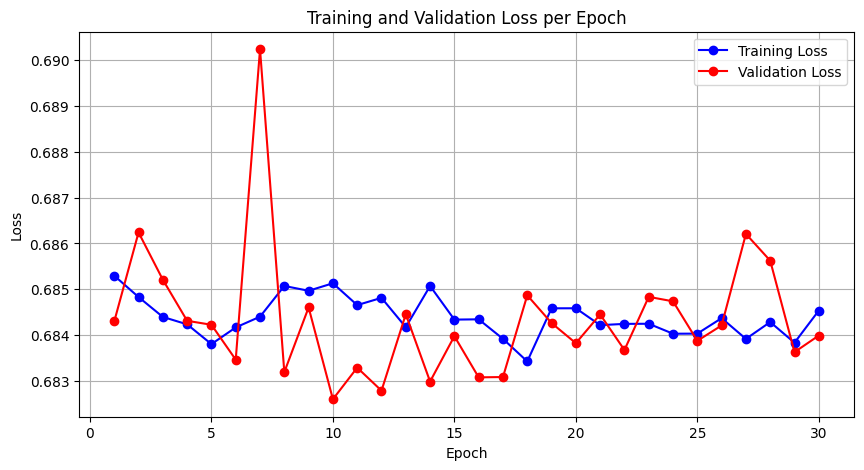

Best Model Training Accuracy: 56.72092632992113%
Best Model Validation Accuracy: 56.8780997128687%


In [23]:
#Training loop
import matplotlib.pyplot as plt

num_epochs = 30  # Number of epochs
losses = []  # List to store the average train loss per epoch
val_losses = []  # List to store the average validation loss per epoch
best_val_loss = float('inf')  # Initialize the best validation loss to infinity
best_epoch = 0  # Epoch with the best validation loss

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0
    total_val_loss = 0
    count = 0
    val_count = 0
    for inputs, labels in train_loader:
        inputs = inputs.unsqueeze(-1).float()
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.squeeze()
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        count += 1
    average_loss = total_loss / count
    losses.append(average_loss)

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.unsqueeze(-1).float()
            val_outputs = model(inputs)
            val_outputs = val_outputs.squeeze()
            val_loss = criterion(val_outputs, labels.float())
            total_val_loss += val_loss.item()
            val_count += 1
    average_val_loss = total_val_loss / val_count
    val_losses.append(average_val_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}, Val Loss: {average_val_loss:.4f}')
    
    # Check if the current validation loss is the lowest; if so, save the model
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), 'rnn_indexing_best_model.pth')  # Save the best model

print(f'Lowest Validation Loss: {best_val_loss:.4f} at Epoch {best_epoch + 1}')

# Plotting the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), losses, 'bo-', label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Load the best model and calculate accuracy only for that
model.load_state_dict(torch.load('rnn_indexing_best_model.pth'))
train_accuracy = calculate_accuracy(train_loader)
val_accuracy = calculate_accuracy(val_loader)
print(f'Best Model Training Accuracy: {train_accuracy}%')
print(f'Best Model Validation Accuracy: {val_accuracy}%')


In [ ]:
# you can test your model
def prepare_test_data(reviews):
    X = torch.tensor(reviews, dtype=torch.float)
    return X

def test_model(model, test_data):
    model.eval()
    with torch.no_grad():
        outputs = model(test_data)
        predicted = (outputs > 0.5).float()
    return predicted

# Prepare test data

# Example review
review = 'HI I am very happy with the product and service'

# Preprocess the review (tokenize and convert to lowercase)
tokens = preprocess_text(review)
print(tokens)

# Convert tokens to indices using the vocabulary
indexed_review = [vocab.get(word, 0) for word in tokens]  # Use 0 for unknown words
print(indexed_review)

# Pad the indexed review to match the input size of the model
max_length = 100  # Ensure this matches the padding length used during training
padded_review = indexed_review[:max_length] + [0] * (max_length - len(indexed_review))

# Prepare test data
test_data = prepare_test_data([padded_review])
test_data = test_data.unsqueeze(-1).float()

# Test the model
predicted = test_model(model, test_data)
print(f'Predicted Suggestion: {predicted.item()}')  # Output will be 0 or 1
# here 0 means - not suggested , 1 means suggested

['hi', 'i', 'am', 'very', 'happy', 'with', 'the', 'product', 'and', 'service']
[927, 46, 1038, 329, 2845, 109, 97, 172, 29, 5769]
Predicted Suggestion: 1.0
